# Rationale
EDA of ATC ontology to other ontology mappings. Main conclusions are: there are lot's of exact duplicates(same source, same classes mapped, probably we are missing some annotation of the mappings here), and quite some different-source  duplicates (different source, same classes mapped, this is sort of expected). There are only 2 relevant sources (CUI & LOOM).

In [15]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from zib_uploader.fetch_data import ClassMappingsFetcher

In [5]:
sns.set_style()

## Fetch data or load from cache

In [6]:
mappings_filepath = 'mappings.csv'
try:
    mappings = pd.read_csv(mappings_filepath)
except FileNotFoundError:
    fetcher = ClassMappingsFetcher()
    data = fetcher.fetch()
    mappings = pd.DataFrame({'source': mapping.source,
                             'atc_class': mapping.classes[0],
                             'mapped_class': mapping.classes[1]}
                            for mapping in data)
mappings.to_csv('mappings.csv', index=False)

In [7]:
mappings.head()

,source,atc_class,mapped_class
0,CUI,http://purl.bioontology.org/ontology/UATC/A03AX13,http://purl.bioontology.org/ontology/NDDF/010500
1,CUI,http://purl.bioontology.org/ontology/UATC/A03AX13,http://purl.bioontology.org/ontology/MSHFRE/D0...
2,CUI,http://purl.bioontology.org/ontology/UATC/A03AX13,http://purl.bioontology.org/ontology/MESH/D012828
3,LOOM,http://purl.bioontology.org/ontology/UATC/A03AX13,http://purl.bioontology.org/ontology/MESH/D012828
4,CUI,http://purl.bioontology.org/ontology/UATC/A03AX13,http://purl.bioontology.org/ontology/SCTSPA/35...


## Deduct mapped ontology

In [8]:
def get_ontology_name(uri):
    return '/'.join(uri.split('/')[:-1])
mappings['mapped_ontology_name'] = mappings['mapped_class'].apply(get_ontology_name)

In [9]:
mappings.head()

,source,atc_class,mapped_class,mapped_ontology_name
0,CUI,http://purl.bioontology.org/ontology/UATC/A03AX13,http://purl.bioontology.org/ontology/NDDF/010500,http://purl.bioontology.org/ontology/NDDF
1,CUI,http://purl.bioontology.org/ontology/UATC/A03AX13,http://purl.bioontology.org/ontology/MSHFRE/D0...,http://purl.bioontology.org/ontology/MSHFRE
2,CUI,http://purl.bioontology.org/ontology/UATC/A03AX13,http://purl.bioontology.org/ontology/MESH/D012828,http://purl.bioontology.org/ontology/MESH
3,LOOM,http://purl.bioontology.org/ontology/UATC/A03AX13,http://purl.bioontology.org/ontology/MESH/D012828,http://purl.bioontology.org/ontology/MESH
4,CUI,http://purl.bioontology.org/ontology/UATC/A03AX13,http://purl.bioontology.org/ontology/SCTSPA/35...,http://purl.bioontology.org/ontology/SCTSPA


## Poop out some statistics

In [78]:
mappings_no_duplicates = mappings.drop_duplicates()

### Number of mappings per ATC class

In [79]:
print(f'{len(mappings)} mappings for {len(mappings["atc_class"].unique())} ATC classes')
print(f'{len(mappings)-len(mappings_no_duplicates)} duplicate mappings (this is kind of weird)')

240000 mappings for 4015 ATC classes
137479 duplicate mappings (this is kind of weird)


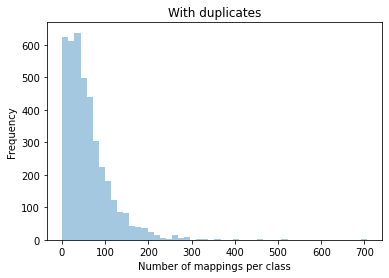

In [81]:
sns.distplot(mappings['atc_class'].value_counts(), hist=True, kde=False)
plt.xlabel('Number of mappings per class')
plt.title('With duplicates')
y = plt.ylabel('Frequency')

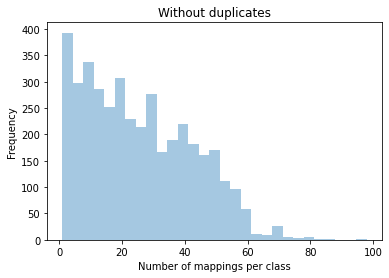

In [82]:
sns.distplot(mappings_no_duplicates['atc_class'].value_counts(), hist=True, kde=False)
plt.xlabel('Number of mappings per class')
plt.title('Without duplicates')
y = plt.ylabel('Frequency')

### Number of mappings per source

In [83]:
mappings_no_duplicates['source'].value_counts()

LOOM        63765
CUI         38639
SAME_URI      117
Name: source, dtype: int64

### Number of mappings per ontology

In [84]:
def source_counts(df):
    result_df = pd.DataFrame(df['mapped_ontology_name'].value_counts())
    result_df.columns = ['total_count']

    for source in df['source'].unique():
        source_df =  pd.DataFrame(df[df['source'] == source]['mapped_ontology_name'].value_counts())
        source_df.columns = [f'{source}_count']
        result_df = result_df.merge(source_df, how='left',left_index=True, right_index=True)

    return result_df.fillna(0).astype(int)

In [111]:
source_counts(mappings_no_duplicates).head(50)

,total_count,CUI_count,LOOM_count,SAME_URI_count
http://purl.bioontology.org/ontology/SNOMEDCT,8336,5713,2623,0
http://purl.obolibrary.org/obo,6583,0,6583,0
http://purl.bioontology.org/ontology/NDFRT,6447,4579,1868,0
http://purl.bioontology.org/ontology/MESH,6181,3464,2717,0
http://purl.bioontology.org/ontology/SCTSPA,5670,5670,0,0
http://purl.bioontology.org/ontology/RXNORM,5524,3013,2511,0
http://phenomebrowser.net/ontologies/mesh,5523,0,5523,0
http://purl.bioontology.org/ontology/NDDF,5330,3209,2121,0
http://purl.bioontology.org/ontology/LNC,5082,2755,2327,0
http://purl.bioontology.org/ontology/VANDF,4395,2446,1949,0


### Note that all mappings from source SAME_URI are for the http://purl.bioontology.org/ontology/STY ontology. These are semantic types, not medicines.

In [95]:
mappings_no_duplicates[mappings_no_duplicates['mapped_ontology_name'] == 'http://purl.bioontology.org/ontology/STY']

,source,atc_class,mapped_class,mapped_ontology_name
1175,SAME_URI,http://purl.bioontology.org/ontology/STY/T057,http://purl.bioontology.org/ontology/STY/T057,http://purl.bioontology.org/ontology/STY
1849,SAME_URI,http://purl.bioontology.org/ontology/STY/T047,http://purl.bioontology.org/ontology/STY/T047,http://purl.bioontology.org/ontology/STY
2286,SAME_URI,http://purl.bioontology.org/ontology/STY/T167,http://purl.bioontology.org/ontology/STY/T167,http://purl.bioontology.org/ontology/STY
5050,SAME_URI,http://purl.bioontology.org/ontology/STY/T066,http://purl.bioontology.org/ontology/STY/T066,http://purl.bioontology.org/ontology/STY
5217,SAME_URI,http://purl.bioontology.org/ontology/STY/T184,http://purl.bioontology.org/ontology/STY/T184,http://purl.bioontology.org/ontology/STY
...,...,...,...,...
229265,SAME_URI,http://purl.bioontology.org/ontology/STY/T023,http://purl.bioontology.org/ontology/STY/T023,http://purl.bioontology.org/ontology/STY
229539,SAME_URI,http://purl.bioontology.org/ontology/STY/T096,http://purl.bioontology.org/ontology/STY/T096,http://purl.bioontology.org/ontology/STY
231224,SAME_URI,http://purl.bioontology.org/ontology/STY/T015,http://purl.bioontology.org/ontology/STY/T015,http://purl.bioontology.org/ontology/STY
233999,SAME_URI,http://purl.bioontology.org/ontology/STY/T032,http://purl.bioontology.org/ontology/STY/T032,http://purl.bioontology.org/ontology/STY


### For some mappings both CUI and LOOM are stated as a source

In [107]:
multiple_sources = mappings_no_duplicates[mappings_no_duplicates.duplicated(subset=['atc_class', 'mapped_class'], keep=False)]

In [108]:
multiple_sources.sort_values(['atc_class', 'mapped_class'])

,source,atc_class,mapped_class,mapped_ontology_name
150133,CUI,http://purl.bioontology.org/ontology/UATC/A01AA01,http://purl.bioontology.org/ontology/HL7/C0037508,http://purl.bioontology.org/ontology/HL7
150134,LOOM,http://purl.bioontology.org/ontology/UATC/A01AA01,http://purl.bioontology.org/ontology/HL7/C0037508,http://purl.bioontology.org/ontology/HL7
150215,CUI,http://purl.bioontology.org/ontology/UATC/A01AA01,http://purl.bioontology.org/ontology/MESH/D012969,http://purl.bioontology.org/ontology/MESH
150216,LOOM,http://purl.bioontology.org/ontology/UATC/A01AA01,http://purl.bioontology.org/ontology/MESH/D012969,http://purl.bioontology.org/ontology/MESH
150126,CUI,http://purl.bioontology.org/ontology/UATC/A01AA01,http://purl.bioontology.org/ontology/NDDF/001103,http://purl.bioontology.org/ontology/NDDF
...,...,...,...,...
87416,LOOM,http://purl.bioontology.org/ontology/UATC/V10XA02,http://purl.bioontology.org/ontology/SNOMEDCT/...,http://purl.bioontology.org/ontology/SNOMEDCT
198266,CUI,http://purl.bioontology.org/ontology/UATC/V10XX01,http://purl.bioontology.org/ontology/SNOMEDCT/...,http://purl.bioontology.org/ontology/SNOMEDCT
198267,LOOM,http://purl.bioontology.org/ontology/UATC/V10XX01,http://purl.bioontology.org/ontology/SNOMEDCT/...,http://purl.bioontology.org/ontology/SNOMEDCT
235774,CUI,http://purl.bioontology.org/ontology/UATC/V10XX04,http://purl.bioontology.org/ontology/SNOMEDCT/...,http://purl.bioontology.org/ontology/SNOMEDCT


### Some classes in the ATC ontology are mapped to multiple classes in other ontologies
An example is 'silicones' in ATC which is mapped to 'Silicone' and 'Silicone-containing product' in Snowmed
Below are some more examples for snowmed

In [116]:
snomed_df = mappings_no_duplicates[mappings_no_duplicates['mapped_ontology_name'] == 'http://purl.bioontology.org/ontology/SNOMEDCT']
snomed_df = snomed_df.drop(columns=['mapped_ontology_name'])

In [121]:
pd.set_option('display.max_colwidth', None)
snomed_df[snomed_df.duplicated(subset=['atc_class', 'source'], keep=False)].head(30)

,source,atc_class,mapped_class
12,CUI,http://purl.bioontology.org/ontology/UATC/A03AX13,http://purl.bioontology.org/ontology/SNOMEDCT/13652007
19,CUI,http://purl.bioontology.org/ontology/UATC/A03AX13,http://purl.bioontology.org/ontology/SNOMEDCT/350103006
115,CUI,http://purl.bioontology.org/ontology/UATC/G03GA04,http://purl.bioontology.org/ontology/SNOMEDCT/126185008
133,CUI,http://purl.bioontology.org/ontology/UATC/G03GA04,http://purl.bioontology.org/ontology/SNOMEDCT/395920003
250,CUI,http://purl.bioontology.org/ontology/UATC/D04AA10,http://purl.bioontology.org/ontology/SNOMEDCT/372871004
264,CUI,http://purl.bioontology.org/ontology/UATC/D04AA10,http://purl.bioontology.org/ontology/SNOMEDCT/8372007
321,CUI,http://purl.bioontology.org/ontology/UATC/L03AA09,http://purl.bioontology.org/ontology/SNOMEDCT/388375003
322,CUI,http://purl.bioontology.org/ontology/UATC/L03AA09,http://purl.bioontology.org/ontology/SNOMEDCT/108967001
339,CUI,http://purl.bioontology.org/ontology/UATC/B01AC23,http://purl.bioontology.org/ontology/SNOMEDCT/116087001
414,CUI,http://purl.bioontology.org/ontology/UATC/B01AC23,http://purl.bioontology.org/ontology/SNOMEDCT/395239000
